## Nikshay Jain - MM21B044
### Assign 6

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.linalg import inv
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
from unidecode import unidecode
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from datasets import load_dataset, DatasetDict
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

c:\Users\Nikshay Jain\AppData\Local\Programs\Python\Python38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Get the dataset

In [3]:
data = load_dataset("qanastek/MASSIVE", trust_remote_code=True)
print(data)

DatasetDict({
    train: Dataset({
        features: ['id', 'locale', 'partition', 'scenario', 'intent', 'utt', 'annot_utt', 'tokens', 'ner_tags', 'worker_id', 'slot_method', 'judgments'],
        num_rows: 587214
    })
    validation: Dataset({
        features: ['id', 'locale', 'partition', 'scenario', 'intent', 'utt', 'annot_utt', 'tokens', 'ner_tags', 'worker_id', 'slot_method', 'judgments'],
        num_rows: 103683
    })
    test: Dataset({
        features: ['id', 'locale', 'partition', 'scenario', 'intent', 'utt', 'annot_utt', 'tokens', 'ner_tags', 'worker_id', 'slot_method', 'judgments'],
        num_rows: 151674
    })
})


In [4]:
des_col = ['locale', 'partition', 'utt', 'tokens']

data1 = DatasetDict({
    'train': data['train'].select_columns(des_col),
    'validation': data['validation'].select_columns(des_col),
    'test': data['test'].select_columns(des_col)
})

print(data1)

DatasetDict({
    train: Dataset({
        features: ['locale', 'partition', 'utt', 'tokens'],
        num_rows: 587214
    })
    validation: Dataset({
        features: ['locale', 'partition', 'utt', 'tokens'],
        num_rows: 103683
    })
    test: Dataset({
        features: ['locale', 'partition', 'utt', 'tokens'],
        num_rows: 151674
    })
})


## Task 1

Create files in a folder named utts_by_locale

In [5]:
locales = ['af-ZA', 'da-DK', 'de-DE', 'en-US', 'es-ES', 'fr-FR', 'fi-FI', 'hu-HU', 'is-IS', 
           'it-IT', 'jv-ID', 'lv-LV', 'ms-MY', 'nb-NO', 'nl-NL', 'pl-PL', 'pt-PT', 
           'ro-RO', 'ru-RU', 'sl-SL', 'sv-SE', 'sq-AL', 'sw-KE', 'tl-PH', 'tr-TR', 
           'vi-VN', 'cy-GB']

# Directory to store output files
output_dir = "utts_by_locale"
os.makedirs(output_dir, exist_ok=True)

# Function to extract and save utterances for each locale for all dataset partitions
def extr_utt(dataset_dict, locales, output_dir, deaccent):
    partitions = ['train', 'validation', 'test']
    for partition in partitions:
        dataset = dataset_dict[partition]
        for locale in locales:
            locale_data = dataset.filter(lambda example: example['locale'] == locale)
            
            file_path = os.path.join(output_dir, f"{locale}_{partition}.txt")
            with open(file_path, 'w', encoding='utf-8') as file:
                for utt in locale_data['utt']:
                    if deaccent:
                        utt = unidecode(utt)
                    file.write(utt + "\n")       # 1 utterance/line
            
            print(f"Saved {locale} utterances from {partition} partition to {file_path}")
            
extr_utt(data1, locales, output_dir, True)

Saved af-ZA utterances from train partition to utts_by_locale\af-ZA_train.txt
Saved da-DK utterances from train partition to utts_by_locale\da-DK_train.txt
Saved de-DE utterances from train partition to utts_by_locale\de-DE_train.txt
Saved en-US utterances from train partition to utts_by_locale\en-US_train.txt
Saved es-ES utterances from train partition to utts_by_locale\es-ES_train.txt
Saved fr-FR utterances from train partition to utts_by_locale\fr-FR_train.txt
Saved fi-FI utterances from train partition to utts_by_locale\fi-FI_train.txt
Saved hu-HU utterances from train partition to utts_by_locale\hu-HU_train.txt
Saved is-IS utterances from train partition to utts_by_locale\is-IS_train.txt
Saved it-IT utterances from train partition to utts_by_locale\it-IT_train.txt
Saved jv-ID utterances from train partition to utts_by_locale\jv-ID_train.txt
Saved lv-LV utterances from train partition to utts_by_locale\lv-LV_train.txt
Saved ms-MY utterances from train partition to utts_by_locale\ms

## Task 2

Create train,val and test sets for Multinomial Naive Bayes Model

In [6]:
# Initialize lists for filtered data and labels for each partition
filtered_train_data, filtered_train_labels = [], []
filtered_val_data, filtered_val_labels = [], []
filtered_test_data, filtered_test_labels = [], []

# Loop through all the files in the output directory and filter by locale and partition
for filename in os.listdir(output_dir):
    if filename.endswith(".txt"):
        file_path = os.path.join(output_dir, filename)
        
        # Extract the locale and partition from the filename
        locale, partition = filename.split('_')[:2]
        
        # Only process if it's in the desired locales
        if locale in locales:
            with open(file_path, 'r', encoding='utf-8') as file:
                utts = file.readlines()
            
            # Strip newlines from utterances
            utts = [utt.strip() for utt in utts]
            
            # Append filtered data and labels based on the partition
            if partition == 'train.txt':
                filtered_train_data.extend(utts)
                filtered_train_labels.extend([locale] * len(utts))
            elif partition == 'validation.txt':
                filtered_val_data.extend(utts)
                filtered_val_labels.extend([locale] * len(utts))
            elif partition == 'test.txt':
                filtered_test_data.extend(utts)
                filtered_test_labels.extend([locale] * len(utts))

In [7]:
# Feature extraction (TF-IDF vectorization)
vectorizer = TfidfVectorizer()

# Vectorize the train, validation, and test data
X_train = vectorizer.fit_transform(filtered_train_data)
y_train = filtered_train_labels

X_val = vectorizer.transform(filtered_val_data)
y_val = filtered_val_labels

X_test = vectorizer.transform(filtered_test_data)
y_test = filtered_test_labels

Get the hyperparameter alpha tuned properly by using validation set

In [8]:
nb_model = MultinomialNB()        # Multinomial Naive Bayes Model

# Grid search to tune 'alpha'
param_grid = {'alpha': [0.01, 0.033, 0.05, 0.067, 0.1]}
grid_search = GridSearchCV(nb_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Training model
nb_model.fit(X_train, y_train)
best_nb_model = grid_search.best_estimator_
print(best_nb_model.get_params())

{'alpha': 0.05, 'class_prior': None, 'fit_prior': True, 'force_alpha': 'warn'}


### Performance Metrics

Training Accuracy: 0.9927013169153173


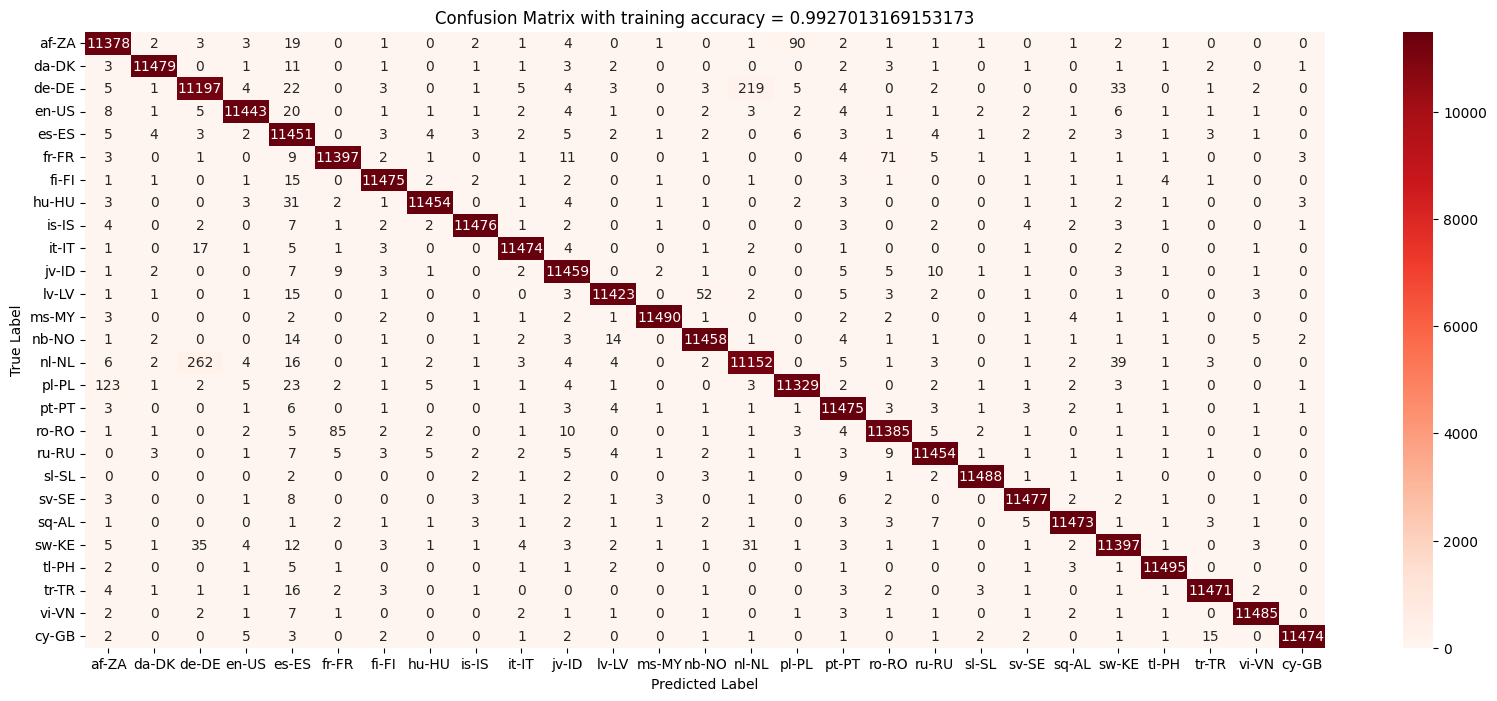

In [9]:
# Evaluate on training set
y_train_pred = best_nb_model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
train_cm = confusion_matrix(y_train, y_train_pred)
print(f"Training Accuracy: {train_accuracy}")

plt.figure(figsize=(20, 8))
sns.heatmap(train_cm, annot=True, fmt='d', cmap='Reds', xticklabels=locales, yticklabels=locales)

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title(f'Confusion Matrix with training accuracy = {train_accuracy}')
plt.show()

Validation Accuracy: 0.9831666393397824


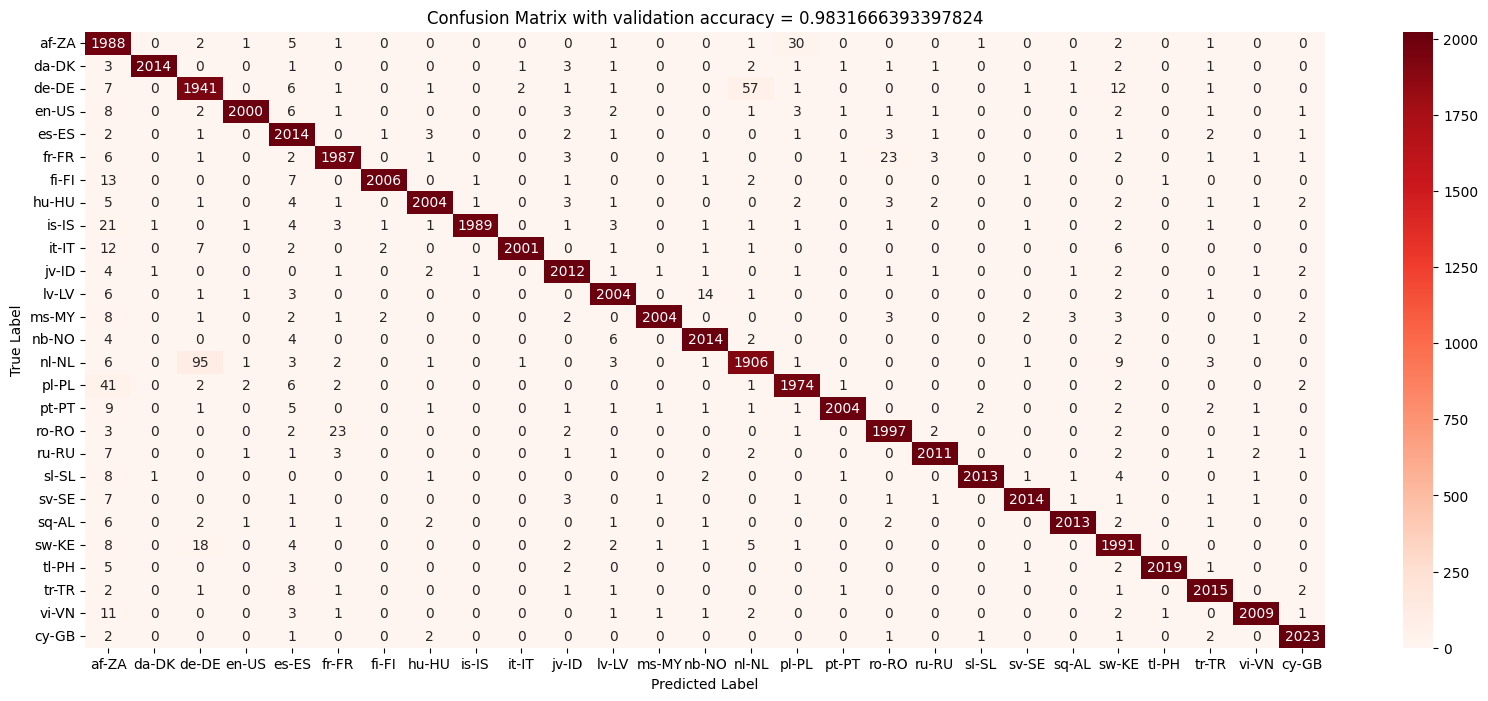

In [10]:
# Evaluate on validation set
y_val_pred = best_nb_model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
val_cm = confusion_matrix(y_val, y_val_pred)
print(f"Validation Accuracy: {val_accuracy}")

plt.figure(figsize=(20, 8))
sns.heatmap(val_cm, annot=True, fmt='d', cmap='Reds', xticklabels=locales, yticklabels=locales)

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title(f'Confusion Matrix with validation accuracy = {val_accuracy}')
plt.show()

Testing Accuracy: 0.9835363271812498


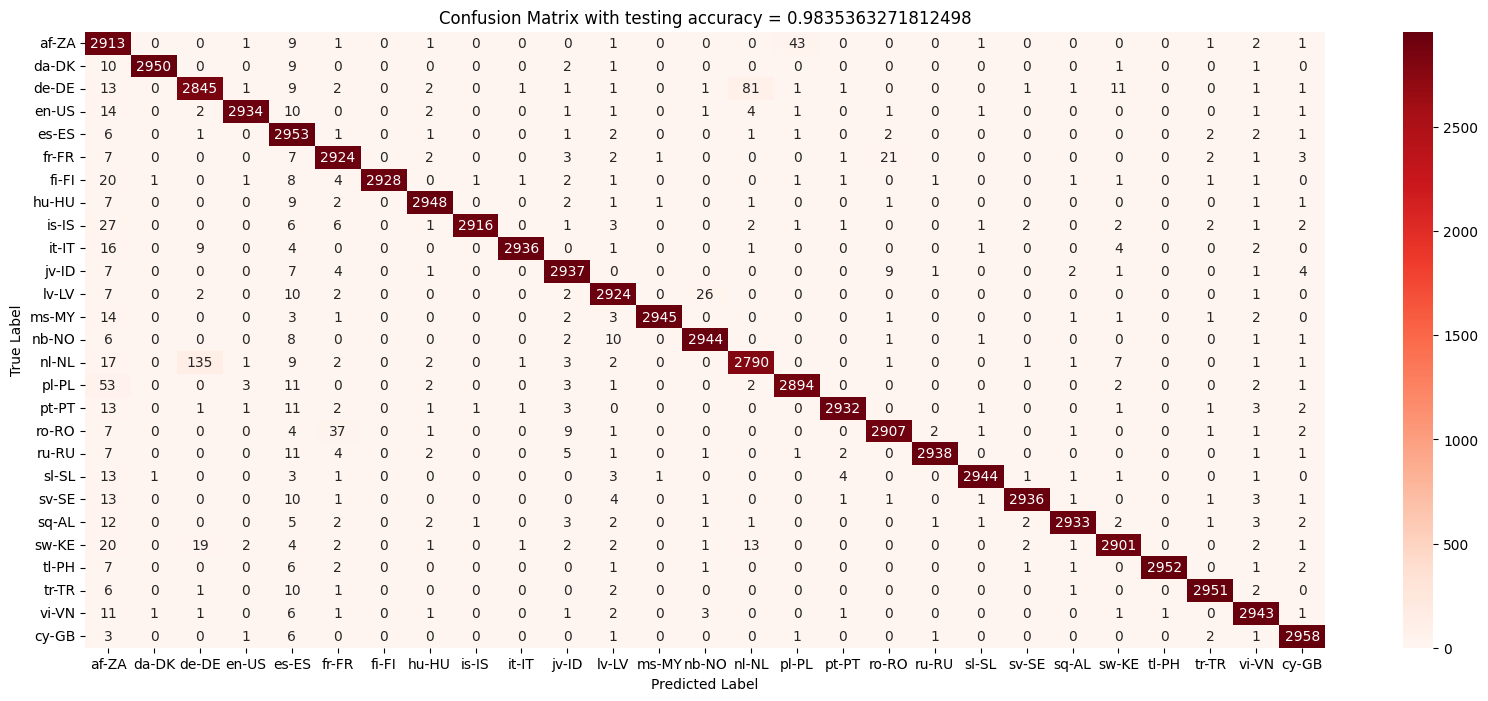

In [11]:
# Evaluate on test set
y_test_pred = best_nb_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_cm = confusion_matrix(y_test, y_test_pred)
print(f"Testing Accuracy: {test_accuracy}")

plt.figure(figsize=(20, 8))
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Reds', xticklabels=locales, yticklabels=locales)

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title(f'Confusion Matrix with testing accuracy = {test_accuracy}')
plt.show()

## Task 3

Create a continent mapping for languages

In [12]:
# Define the mapping of languages to continents
continent_mapping = {
    'af-ZA': 'Africa',
    'da-DK': 'Europe',
    'de-DE': 'Europe',
    'en-US': 'North_America',
    'es-ES': 'Europe',
    'fr-FR': 'Europe',
    'fi-FI': 'Europe',
    'hu-HU': 'Europe',
    'is-IS': 'Europe',
    'it-IT': 'Europe',
    'jv-ID': 'Asia',
    'lv-LV': 'Europe',
    'ms-MY': 'Asia',
    'nb-NO': 'Europe',
    'nl-NL': 'Europe',
    'pl-PL': 'Europe',
    'pt-PT': 'Europe',
    'ro-RO': 'Europe',
    'ru-RU': 'Europe',
    'sl-SL': 'Europe',
    'sv-SE': 'Europe',
    'sq-AL': 'Europe',
    'sw-KE': 'Africa',
    'tl-PH': 'Asia',
    'tr-TR': 'Asia',
    'vi-VN': 'Asia',
    'cy-GB': 'Europe'
}

# Dictionary to hold content for continent
continent_files = {continent: [] for continent in set(continent_mapping.values())}

In [13]:
# Read each language file and append its content to the corresponding continent list
partitions = ['train', 'validation', 'test']
for partition in partitions:
    for lang_code, continent in continent_mapping.items():
        file_path = os.path.join(output_dir, f"{lang_code}_{partition}.txt")
        
        # Check if the file exists before reading
        if os.path.exists(file_path):
            with open(file_path, 'r', encoding='utf-8') as file:
                content = file.readlines()
                continent_files[continent].extend(content)
        else:
            print(f"File {file_path} does not exist.")

Save the txt files as per continents

In [14]:
# Save content for continents in new locations
lang_dir = 'utts_by_continents'
os.makedirs(lang_dir, exist_ok=True)

for continent, lines in continent_files.items():
    output_file_path = os.path.join(lang_dir, f"{continent}.txt")
    with open(output_file_path, 'w', encoding='utf-8') as output_file:
        output_file.writelines(lines)                # Write all lines to the continent file

Traverse throught the continent folder to get the data in pandas dataframe for the model to operate upon

In [15]:
folder_path = output_dir

# List to store DataFrames
train_dfs = []
val_dfs = []
test_dfs = []

# Function to extract the locale from the file name
def extract_locale(file_name):
    return file_name.split('_')[0]

for file_name in os.listdir(folder_path):
    file_path = os.path.join(folder_path, file_name)
    
    locale = extract_locale(file_name)  # Extract the locale (e.g., 'af-ZA')
    
    if '_train.txt' in file_name:
        df = pd.read_csv(file_path, sep='\t', names=['utt'])
        df['locale'] = locale  # Add locale column
        train_dfs.append(df)

    elif '_validation.txt' in file_name:
        df = pd.read_csv(file_path, sep='\t', names=['utt'])
        df['locale'] = locale  # Add locale column
        val_dfs.append(df)

    elif '_test.txt' in file_name:
        df = pd.read_csv(file_path, sep='\t', names=['utt'])
        df['locale'] = locale  # Add locale column
        test_dfs.append(df)

# Concatenate all DataFrames into one
train_data = pd.concat(train_dfs, ignore_index=True)
validation_data = pd.concat(val_dfs, ignore_index=True)
test_data = pd.concat(test_dfs, ignore_index=True)

Vectorize the data and select only relevant features to be trained upon

In [16]:
y_train_continent = train_data['locale'].map(continent_mapping)

# Encode target labels as integers for chi-square test
label_encoder = LabelEncoder()
y_train_continent_encoded = label_encoder.fit_transform(y_train_continent)

# Vectorizer setup (same as before)
vectorizer = TfidfVectorizer(max_features=50000,  # Adjust as needed
                             max_df=0.7,  # Ignore terms that appear in more than 80% of the documents
                             )

# Fit and transform the training data
X_train_tfidf = vectorizer.fit_transform(train_data['utt'])

# Perform chi-square feature selection
chi2_selector = SelectKBest(chi2, k=1000)  # Choose top 5000 features based on chi-square test
X_train_selected = chi2_selector.fit_transform(X_train_tfidf, y_train_continent_encoded)

# Map validation labels to the continent
y_val_continent = validation_data['locale'].map(continent_mapping)
y_val_continent_encoded = label_encoder.transform(y_val_continent)

# Transform the validation data using the same vectorizer and feature selector
X_val_tfidf = vectorizer.transform(validation_data['utt'])
X_val_selected = chi2_selector.transform(X_val_tfidf)

# Map test labels to the continent
y_test_continent = test_data['locale'].map(continent_mapping)
y_test_continent_encoded = label_encoder.transform(y_test_continent)

# Transform the test data using the same vectorizer and feature selector
X_test_tfidf = vectorizer.transform(test_data['utt'])
X_test_selected = chi2_selector.transform(X_test_tfidf)

Create the class for RDA using LDA and QDA

In [18]:
class RegularizedDiscriminantAnalysis(BaseEstimator, ClassifierMixin):
    def __init__(self, lambda_):
        self.lambda_ = lambda_
        self.lda = LinearDiscriminantAnalysis()
        self.qda = QuadraticDiscriminantAnalysis()

    def fit(self, X, y):
        self.lda.fit(X, y)
        self.qda.fit(X, y)
        return self

    def predict(self, X):
        # Combine predictions from LDA and QDA
        lda_prob = self.lda.predict_proba(X)
        qda_prob = self.qda.predict_proba(X)

        # Weighted average of probabilities of LDA and QDA
        combined_prob = self.lambda_ * lda_prob + (1 - self.lambda_) * qda_prob
        
        # Choose the class with the highest probability
        return np.argmax(combined_prob, axis=1)

Fit the model on the data with an apt lambda value

In [19]:
lambda_range = np.linspace(0, 1, 11)  # Search range for lambda values

best_lambda = None
best_score = 0

# Loop over lambda values and perform validation
for lambda_ in lambda_range:
    rda = RegularizedDiscriminantAnalysis(lambda_=lambda_)
    rda.fit(X_train_selected.toarray(), y_train_continent_encoded)
    
    # Predict on the validation data
    y_val_pred = rda.predict(X_val_selected.toarray())
    
    val_score = accuracy_score(y_val_continent_encoded, y_val_pred)
    if val_score > best_score:
        best_score = val_score
        best_lambda = lambda_

# Output the best lambda value
print(f"Best lambda: {best_lambda}, Best validation accuracy: {best_score}")

c:\Users\Nikshay Jain\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\Nikshay Jain\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\Nikshay Jain\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\Nikshay Jain\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\Nikshay Jain\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\Niksha

Best lambda: 0.6000000000000001, Best validation accuracy: 0.9517953762911953


In [20]:
rda = RegularizedDiscriminantAnalysis(lambda_=best_lambda)
rda.fit(X_train_selected.toarray(), y_train_continent_encoded)

c:\Users\Nikshay Jain\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


RegularizedDiscriminantAnalysis(lambda_=0.6000000000000001)

Output the metrics for the optimum model

In [21]:
# Training accuracy
y_train_continent_pred = rda.predict(X_train_selected.toarray())
train_accuracy_continent = accuracy_score(y_train_continent_encoded, y_train_continent_pred)
print(f"Training Accuracy: {train_accuracy_continent:.4f}")

# Validation accuracy
y_val_continent_pred = rda.predict(X_val_selected.toarray())
val_accuracy_continent = accuracy_score(y_val_continent_encoded, y_val_continent_pred)
print(f"Validation Accuracy: {val_accuracy_continent:.4f}")

# Test accuracy
y_test_continent_pred = rda.predict(X_test_selected.toarray())
test_accuracy_continent = accuracy_score(y_test_continent_encoded, y_test_continent_pred)
print(f"Test Accuracy: {test_accuracy_continent:.4f}")

Training Accuracy: 0.9543
Validation Accuracy: 0.9518
Test Accuracy: 0.9525
